`torchvision
models <https://pytorch.org/docs/stable/torchvision/models.html>`

**finetuning**, 

start with a pretrained model and update *all* of the model’s parameters for our new
task, in essence retraining the whole model. 

**feature extraction**,

start with a pretrained model and only update the final layer weights
from which we derive predictions. 

`<https://cs231n.github.io/transfer-learning/>`

`<https://ruder.io/transfer-learning/>`

both methods follow same steps:

-  Initialize the pretrained model
-  Reshape the final layer(s) to have the same number of outputs as the
   number of classes in the new dataset
-  Define for the optimization algorithm which parameters we want to
   update during training
-  Run the training step




In [1]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
%matplotlib inline
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.2.0
Torchvision Version:  0.4.0a0


Inputs
------

Here are all of the parameters to change for the run. We will use the
*hymenoptera_data* dataset which can be downloaded
`here <https://download.pytorch.org/tutorial/hymenoptera_data.zip>`__.
This dataset contains two classes, **bees** and **ants**, and is
structured such that we can use the
`ImageFolder <https://pytorch.org/docs/stable/torchvision/datasets.html#torchvision.datasets.ImageFolder>`__
dataset, rather than writing our own custom dataset. Download the data
and set the ``data_dir`` input to the root directory of the dataset. The
``model_name`` input is the name of the model you wish to use and must
be selected from this list:

::

   [resnet, alexnet, vgg, squeezenet, densenet, inception]

The other inputs are as follows: ``num_classes`` is the number of
classes in the dataset, ``batch_size`` is the batch size used for
training and may be adjusted according to the capability of your
machine, ``num_epochs`` is the number of training epochs we want to run,
and ``feature_extract`` is a boolean that defines if we are finetuning
or feature extracting. If ``feature_extract = False``, the model is
finetuned and all model parameters are updated. If
``feature_extract = True``, only the last layer parameters are updated,
the others remain fixed.




In [3]:
# Top level data directory. Here we assume the format of the directory conforms 
#   to the ImageFolder structure
data_dir = "./data/hymenoptera_data"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "vgg" #"squeezenet"

# Number of classes in the dataset
num_classes = 2

# Batch size for training (change depending on how much memory you have)
batch_size = 20

# Number of epochs to train for 
num_epochs = 5000

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

Helper Functions
----------------

Before we write the code for adjusting the models, lets define a few
helper functions.

Model Training and Validation Code
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

The ``train_model`` function handles the training and validation of a
given model. As input, it takes a PyTorch model, a dictionary of
dataloaders, a loss function, an optimizer, a specified number of epochs
to train and validate for, and a boolean flag for when the model is an
Inception model. The *is_inception* flag is used to accomodate the
*Inception v3* model, as that architecture uses an auxiliary output and
the overall model loss respects both the auxiliary output and the final
output, as described
`here <https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958>`__.
The function trains for the specified number of epochs and after each
epoch runs a full validation step. It also keeps track of the best
performing model (in terms of validation accuracy), and at the end of
training returns the best performing model. After each epoch, the
training and validation accuracies are printed.




In [4]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        # -----------------------
        if epoch % 50 == 0:
            plt.plot(val_acc_history)
            plt.show()
            
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

Set Model Parameters’ .requires_grad attribute
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

This helper function sets the ``.requires_grad`` attribute of the
parameters in the model to False when we are feature extracting. By
default, when we load a pretrained model all of the parameters have
``.requires_grad=True``, which is fine if we are training from scratch
or finetuning. However, if we are feature extracting and only want to
compute gradients for the newly initialized layer then we want all of
the other parameters to not require gradients. This will make more sense
later.




In [5]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            # print("let's set param grad to false", param.shape)
            param.requires_grad = False

Initialize and Reshape the Networks
-----------------------------------

Now to the most interesting part. Here is where we handle the reshaping
of each network. Note, this is not an automatic procedure and is unique
to each model. Recall, the final layer of a CNN model, which is often
times an FC layer, has the same number of nodes as the number of output
classes in the dataset. Since all of the models have been pretrained on
Imagenet, they all have output layers of size 1000, one node for each
class. The goal here is to reshape the last layer to have the same
number of inputs as before, AND to have the same number of outputs as
the number of classes in the dataset. In the following sections we will
discuss how to alter the architecture of each model individually. But
first, there is one important detail regarding the difference between
finetuning and feature-extraction.

When feature extracting, we only want to update the parameters of the
last layer, or in other words, we only want to update the parameters for
the layer(s) we are reshaping. Therefore, we do not need to compute the
gradients of the parameters that we are not changing, so for efficiency
we set the .requires_grad attribute to False. This is important because
by default, this attribute is set to True. Then, when we initialize the
new layer and by default the new parameters have ``.requires_grad=True``
so only the new layer’s parameters will be updated. When we are
finetuning we can leave all of the .required_grad’s set to the default
of True.

Finally, notice that inception_v3 requires the input size to be
(299,299), whereas all of the other models expect (224,224).

Resnet
~~~~~~

Resnet was introduced in the paper `Deep Residual Learning for Image
Recognition <https://arxiv.org/abs/1512.03385>`__. There are several
variants of different sizes, including Resnet18, Resnet34, Resnet50,
Resnet101, and Resnet152, all of which are available from torchvision
models. Here we use Resnet18, as our dataset is small and only has two
classes. When we print the model, we see that the last layer is a fully
connected layer as shown below:

::

   (fc): Linear(in_features=512, out_features=1000, bias=True) 

Thus, we must reinitialize ``model.fc`` to be a Linear layer with 512
input features and 2 output features with:

::

   model.fc = nn.Linear(512, num_classes)

Alexnet
~~~~~~~

Alexnet was introduced in the paper `ImageNet Classification with Deep
Convolutional Neural
Networks <https://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks.pdf>`__
and was the first very successful CNN on the ImageNet dataset. When we
print the model architecture, we see the model output comes from the 6th
layer of the classifier

::

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    ) 

To use the model with our dataset we reinitialize this layer as

::

   model.classifier[6] = nn.Linear(4096,num_classes)

VGG
~~~

VGG was introduced in the paper `Very Deep Convolutional Networks for
Large-Scale Image Recognition <https://arxiv.org/pdf/1409.1556.pdf>`__.
Torchvision offers eight versions of VGG with various lengths and some
that have batch normalizations layers. Here we use VGG-11 with batch
normalization. The output layer is similar to Alexnet, i.e.

::

   (classifier): Sequential(
       ...
       (6): Linear(in_features=4096, out_features=1000, bias=True)
    )

Therefore, we use the same technique to modify the output layer

::

   model.classifier[6] = nn.Linear(4096,num_classes)

Squeezenet
~~~~~~~~~~

The Squeeznet architecture is described in the paper `SqueezeNet:
AlexNet-level accuracy with 50x fewer parameters and <0.5MB model
size <https://arxiv.org/abs/1602.07360>`__ and uses a different output
structure than any of the other models shown here. Torchvision has two
versions of Squeezenet, we use version 1.0. The output comes from a 1x1
convolutional layer which is the 1st layer of the classifier:

::

   (classifier): Sequential(
       (0): Dropout(p=0.5)
       (1): Conv2d(512, 1000, kernel_size=(1, 1), stride=(1, 1))
       (2): ReLU(inplace)
       (3): AvgPool2d(kernel_size=13, stride=1, padding=0)
    ) 

To modify the network, we reinitialize the Conv2d layer to have an
output feature map of depth 2 as

::

   model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))

Densenet
~~~~~~~~

Densenet was introduced in the paper `Densely Connected Convolutional
Networks <https://arxiv.org/abs/1608.06993>`__. Torchvision has four
variants of Densenet but here we only use Densenet-121. The output layer
is a linear layer with 1024 input features:

::

   (classifier): Linear(in_features=1024, out_features=1000, bias=True) 

To reshape the network, we reinitialize the classifier’s linear layer as

::

   model.classifier = nn.Linear(1024, num_classes)

Inception v3
~~~~~~~~~~~~

Finally, Inception v3 was first described in `Rethinking the Inception
Architecture for Computer
Vision <https://arxiv.org/pdf/1512.00567v1.pdf>`__. This network is
unique because it has two output layers when training. The second output
is known as an auxiliary output and is contained in the AuxLogits part
of the network. The primary output is a linear layer at the end of the
network. Note, when testing we only consider the primary output. The
auxiliary output and primary output of the loaded model are printed as:

::

   (AuxLogits): InceptionAux(
       ...
       (fc): Linear(in_features=768, out_features=1000, bias=True)
    )
    ...
   (fc): Linear(in_features=2048, out_features=1000, bias=True)

To finetune this model we must reshape both layers. This is accomplished
with the following

::

   model.AuxLogits.fc = nn.Linear(768, num_classes)
   model.fc = nn.Linear(2048, num_classes)

Notice, many of the models have similar output structures, but each must
be handled slightly differently. Also, check out the printed model
architecture of the reshaped network and make sure the number of output
features is the same as the number of classes in the dataset.




In [6]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        print("Before change:", model_ft)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[1].in_features
        # model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft.classifier = nn.Sequential(*[model_ft.classifier[0], nn.Linear(num_ftrs,num_classes)])
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg19(pretrained=use_pretrained)
        print("Before change:", model_ft)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[0].in_features
        # model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        model_ft.classifier = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes) 
        input_size = 224

    elif model_name == "inception":
        """ Inception v3 
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated

print('After change:', model_ft)
for name,param in model_ft.named_parameters():
    print("\t",name, param.requires_grad)


Before change: VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stri

Load Data
---------

Now that we know what the input size must be, we can initialize the data
transforms, image datasets, and the dataloaders. Notice, the models were
pretrained with the hard-coded normalization values, as described
`here <https://pytorch.org/docs/master/torchvision/models.html>`__.




In [7]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [8]:
device

device(type='cuda', index=0)

Create the Optimizer
--------------------

Now that the model structure is correct, the final step for finetuning
and feature extracting is to create an optimizer that only updates the
desired parameters. Recall that after loading the pretrained model, but
before reshaping, if ``feature_extract=True`` we manually set all of the
parameter’s ``.requires_grad`` attributes to False. Then the
reinitialized layer’s parameters have ``.requires_grad=True`` by
default. So now we know that *all parameters that have
.requires_grad=True should be optimized.* Next, we make a list of such
parameters and input this list to the SGD algorithm constructor.

To verify this, check out the printed parameters to learn. When
finetuning, this list should be long and include all of the model
parameters. However, when feature extracting this list should be short
and only include the weights and biases of the reshaped layers.




In [9]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.weight
	 classifier.bias


Run Training and Validation Step
--------------------------------

Finally, the last step is to setup the loss for the model, then run the
training and validation function for the set number of epochs. Notice,
depending on the number of epochs this step may take a while on a CPU.
Also, the default learning rate is not optimal for all of the models, so
to achieve maximum accuracy it would be necessary to tune for each model
separately.




Epoch 0/4999
----------


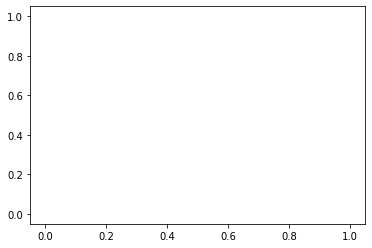

train Loss: 0.3618 Acc: 0.8525
val Loss: 0.4049 Acc: 0.9216

Epoch 1/4999
----------
train Loss: 0.2670 Acc: 0.9221
val Loss: 0.5742 Acc: 0.9085

Epoch 2/4999
----------
train Loss: 0.2620 Acc: 0.9221
val Loss: 0.4661 Acc: 0.9085

Epoch 3/4999
----------
train Loss: 0.2374 Acc: 0.9508
val Loss: 0.3970 Acc: 0.9346

Epoch 4/4999
----------
train Loss: 0.2018 Acc: 0.9467
val Loss: 0.4090 Acc: 0.9281

Epoch 5/4999
----------
train Loss: 0.1594 Acc: 0.9590
val Loss: 0.4066 Acc: 0.9216

Epoch 6/4999
----------
train Loss: 0.1898 Acc: 0.9467
val Loss: 0.3587 Acc: 0.9281

Epoch 7/4999
----------
train Loss: 0.2865 Acc: 0.9262
val Loss: 0.3541 Acc: 0.9346

Epoch 8/4999
----------
train Loss: 0.3117 Acc: 0.9303
val Loss: 0.3911 Acc: 0.9150

Epoch 9/4999
----------
train Loss: 0.1142 Acc: 0.9590
val Loss: 0.3132 Acc: 0.9477

Epoch 10/4999
----------
train Loss: 0.1546 Acc: 0.9631
val Loss: 0.3361 Acc: 0.9281

Epoch 11/4999
----------
train Loss: 0.0902 Acc: 0.9795
val Loss: 0.5227 Acc: 0.9085

Ep

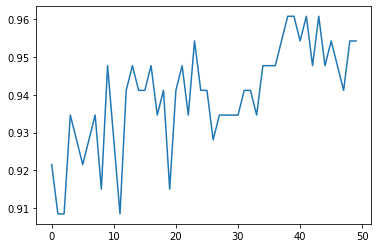

train Loss: 0.0785 Acc: 0.9795
val Loss: 0.3829 Acc: 0.9608

Epoch 51/4999
----------
train Loss: 0.0600 Acc: 0.9836
val Loss: 0.3954 Acc: 0.9412

Epoch 52/4999
----------
train Loss: 0.0535 Acc: 0.9836
val Loss: 0.3809 Acc: 0.9608

Epoch 53/4999
----------
train Loss: 0.0538 Acc: 0.9918
val Loss: 0.3758 Acc: 0.9542

Epoch 54/4999
----------
train Loss: 0.0852 Acc: 0.9713
val Loss: 0.3467 Acc: 0.9542

Epoch 55/4999
----------
train Loss: 0.2255 Acc: 0.9713
val Loss: 0.4030 Acc: 0.9477

Epoch 56/4999
----------
train Loss: 0.0387 Acc: 0.9877
val Loss: 0.4831 Acc: 0.9542

Epoch 57/4999
----------
train Loss: 0.1522 Acc: 0.9754
val Loss: 0.4206 Acc: 0.9412

Epoch 58/4999
----------
train Loss: 0.1140 Acc: 0.9754
val Loss: 0.4344 Acc: 0.9412

Epoch 59/4999
----------
train Loss: 0.0968 Acc: 0.9754
val Loss: 0.4377 Acc: 0.9281

Epoch 60/4999
----------
train Loss: 0.1297 Acc: 0.9713
val Loss: 0.3704 Acc: 0.9412

Epoch 61/4999
----------
train Loss: 0.3121 Acc: 0.9549
val Loss: 0.4596 Acc: 0

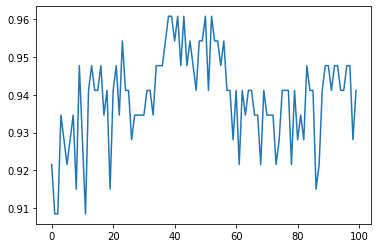

train Loss: 0.0590 Acc: 0.9836
val Loss: 0.7576 Acc: 0.9542

Epoch 101/4999
----------
train Loss: 0.1410 Acc: 0.9754
val Loss: 0.7186 Acc: 0.9477

Epoch 102/4999
----------
train Loss: 0.0705 Acc: 0.9672
val Loss: 0.6991 Acc: 0.9477

Epoch 103/4999
----------
train Loss: 0.0796 Acc: 0.9713
val Loss: 0.6884 Acc: 0.9477

Epoch 104/4999
----------
train Loss: 0.1225 Acc: 0.9795
val Loss: 0.6917 Acc: 0.9412

Epoch 105/4999
----------
train Loss: 0.0674 Acc: 0.9877
val Loss: 0.6851 Acc: 0.9412

Epoch 106/4999
----------
train Loss: 0.0454 Acc: 0.9918
val Loss: 0.6784 Acc: 0.9477

Epoch 107/4999
----------
train Loss: 0.0861 Acc: 0.9754
val Loss: 0.7986 Acc: 0.9412

Epoch 108/4999
----------
train Loss: 0.0885 Acc: 0.9877
val Loss: 0.7484 Acc: 0.9542

Epoch 109/4999
----------
train Loss: 0.0618 Acc: 0.9713
val Loss: 0.8058 Acc: 0.9412

Epoch 110/4999
----------
train Loss: 0.0774 Acc: 0.9836
val Loss: 0.7600 Acc: 0.9346

Epoch 111/4999
----------
train Loss: 0.0998 Acc: 0.9713
val Loss: 0.

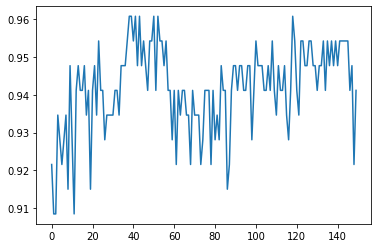

train Loss: 0.0268 Acc: 0.9918
val Loss: 0.7759 Acc: 0.9477

Epoch 151/4999
----------
train Loss: 0.0472 Acc: 0.9795
val Loss: 0.9271 Acc: 0.9412

Epoch 152/4999
----------
train Loss: 0.0442 Acc: 0.9877
val Loss: 0.9115 Acc: 0.9412

Epoch 153/4999
----------
train Loss: 0.1228 Acc: 0.9590
val Loss: 0.9232 Acc: 0.9477

Epoch 154/4999
----------
train Loss: 0.0896 Acc: 0.9713
val Loss: 0.8950 Acc: 0.9412

Epoch 155/4999
----------
train Loss: 0.0781 Acc: 0.9877
val Loss: 0.8831 Acc: 0.9412

Epoch 156/4999
----------
train Loss: 0.0712 Acc: 0.9795
val Loss: 0.8791 Acc: 0.9412

Epoch 157/4999
----------
train Loss: 0.0882 Acc: 0.9877
val Loss: 0.8760 Acc: 0.9412

Epoch 158/4999
----------
train Loss: 0.0307 Acc: 0.9918
val Loss: 0.8646 Acc: 0.9412

Epoch 159/4999
----------
train Loss: 0.0331 Acc: 0.9918
val Loss: 0.8634 Acc: 0.9477

Epoch 160/4999
----------
train Loss: 0.0103 Acc: 0.9877
val Loss: 0.8629 Acc: 0.9542

Epoch 161/4999
----------
train Loss: 0.0332 Acc: 0.9918
val Loss: 0.

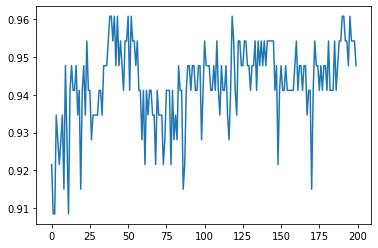

train Loss: 0.0650 Acc: 0.9877
val Loss: 0.8149 Acc: 0.9477

Epoch 201/4999
----------
train Loss: 0.0126 Acc: 0.9959
val Loss: 0.8241 Acc: 0.9608

Epoch 202/4999
----------
train Loss: 0.0125 Acc: 0.9918
val Loss: 0.7955 Acc: 0.9608

Epoch 203/4999
----------
train Loss: 0.0710 Acc: 0.9836
val Loss: 0.8016 Acc: 0.9608

Epoch 204/4999
----------
train Loss: 0.0221 Acc: 0.9959
val Loss: 0.8161 Acc: 0.9542

Epoch 205/4999
----------
train Loss: 0.0209 Acc: 0.9877
val Loss: 0.8247 Acc: 0.9477

Epoch 206/4999
----------
train Loss: 0.0786 Acc: 0.9795
val Loss: 0.8415 Acc: 0.9542

Epoch 207/4999
----------
train Loss: 0.0312 Acc: 0.9877
val Loss: 0.8684 Acc: 0.9542

Epoch 208/4999
----------
train Loss: 0.0706 Acc: 0.9877
val Loss: 0.8586 Acc: 0.9477

Epoch 209/4999
----------
train Loss: 0.0132 Acc: 0.9959
val Loss: 0.8639 Acc: 0.9542

Epoch 210/4999
----------
train Loss: 0.0288 Acc: 0.9918
val Loss: 0.8696 Acc: 0.9542

Epoch 211/4999
----------
train Loss: 0.0201 Acc: 0.9918
val Loss: 0.

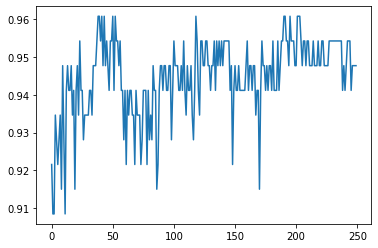

train Loss: 0.0590 Acc: 0.9836
val Loss: 0.8231 Acc: 0.9542

Epoch 251/4999
----------
train Loss: 0.0147 Acc: 0.9918
val Loss: 0.8622 Acc: 0.9542

Epoch 252/4999
----------
train Loss: 0.0196 Acc: 0.9959
val Loss: 0.8732 Acc: 0.9542

Epoch 253/4999
----------
train Loss: 0.0509 Acc: 0.9836
val Loss: 0.8692 Acc: 0.9542

Epoch 254/4999
----------
train Loss: 0.0750 Acc: 0.9754
val Loss: 0.8540 Acc: 0.9412

Epoch 255/4999
----------
train Loss: 0.0510 Acc: 0.9918
val Loss: 0.8258 Acc: 0.9412

Epoch 256/4999
----------
train Loss: 0.0324 Acc: 0.9877
val Loss: 0.8215 Acc: 0.9542

Epoch 257/4999
----------
train Loss: 0.1001 Acc: 0.9836
val Loss: 0.8352 Acc: 0.9542

Epoch 258/4999
----------
train Loss: 0.0479 Acc: 0.9877
val Loss: 0.8026 Acc: 0.9412

Epoch 259/4999
----------
train Loss: 0.0497 Acc: 0.9836
val Loss: 0.7969 Acc: 0.9412

Epoch 260/4999
----------
train Loss: 0.0791 Acc: 0.9754
val Loss: 0.7900 Acc: 0.9542

Epoch 261/4999
----------
train Loss: 0.0364 Acc: 0.9795
val Loss: 0.

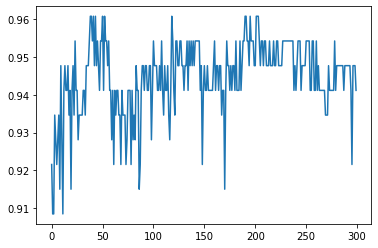

train Loss: 0.0068 Acc: 0.9959
val Loss: 0.9289 Acc: 0.9477

Epoch 301/4999
----------
train Loss: 0.0258 Acc: 0.9877
val Loss: 0.9383 Acc: 0.9412

Epoch 302/4999
----------
train Loss: 0.0919 Acc: 0.9795
val Loss: 0.9047 Acc: 0.9412

Epoch 303/4999
----------
train Loss: 0.0092 Acc: 0.9959
val Loss: 0.8994 Acc: 0.9477

Epoch 304/4999
----------
train Loss: 0.0352 Acc: 0.9836
val Loss: 0.9152 Acc: 0.9477

Epoch 305/4999
----------
train Loss: 0.0286 Acc: 0.9836
val Loss: 0.9197 Acc: 0.9477

Epoch 306/4999
----------
train Loss: 0.0581 Acc: 0.9918
val Loss: 0.9362 Acc: 0.9542

Epoch 307/4999
----------
train Loss: 0.0423 Acc: 0.9836
val Loss: 0.9184 Acc: 0.9542

Epoch 308/4999
----------
train Loss: 0.0930 Acc: 0.9754
val Loss: 0.9227 Acc: 0.9542

Epoch 309/4999
----------
train Loss: 0.0294 Acc: 0.9877
val Loss: 1.0172 Acc: 0.9412

Epoch 310/4999
----------
train Loss: 0.0429 Acc: 0.9836
val Loss: 1.0108 Acc: 0.9412

Epoch 311/4999
----------
train Loss: 0.0735 Acc: 0.9877
val Loss: 0.

KeyboardInterrupt: 

In [10]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [ ]:

if model_name == "alexnet":
    torch.save(model_ft.state_dict()['classifier.1.weight'], 'ant_bee_Alexnet_FC_25088_2_acc8889_weight.pt')
    torch.save(model_ft.state_dict()['classifier.1.bias'], 'ant_bee_Alexnet_FC_25088_2_acc8889_bias.pt')
elif model_name == "vgg":
    torch.save(model_ft.state_dict()['classifier.weight'], 'ant_bee_VGG19_FC_25088_2_acc9542_weight.pt')
    torch.save(model_ft.state_dict()['classifier.bias'], 'ant_bee_VGG19_FC_25088_2_acc9542_bias.pt')

In [13]:
model_ft.state_dict()['classifier.weight'].shape

torch.Size([2, 25088])

In [14]:
model_ft.state_dict()['classifier.bias'].shape

torch.Size([2])

Comparison with Model Trained from Scratch
------------------------------------------

See how the model learns if we do not use transfer
learning. The performance of finetuning vs. feature extracting depends
largely on the dataset but in general both transfer learning methods
produce favorable results in terms of training time and overall accuracy
versus a model trained from scratch.




	 features.0.weight False
	 features.0.bias False
	 features.2.weight False
	 features.2.bias False
	 features.5.weight False
	 features.5.bias False
	 features.7.weight False
	 features.7.bias False
	 features.10.weight False
	 features.10.bias False
	 features.12.weight False
	 features.12.bias False
	 features.14.weight False
	 features.14.bias False
	 features.16.weight False
	 features.16.bias False
	 features.19.weight False
	 features.19.bias False
	 features.21.weight False
	 features.21.bias False
	 features.23.weight False
	 features.23.bias False
	 features.25.weight False
	 features.25.bias False
	 features.28.weight False
	 features.28.bias False
	 features.30.weight False
	 features.30.bias False
	 features.32.weight False
	 features.32.bias False
	 features.34.weight False
	 features.34.bias False
	 classifier.0.weight True
	 classifier.0.bias True
	 classifier.3.weight True
	 classifier.3.bias True
	 classifier.6.weight True
	 classifier.6.bias True
VGG(
  (features): S

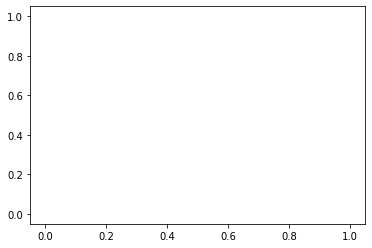

train Loss: 7.9426 Acc: 0.2582
val Loss: 0.9043 Acc: 0.8693

Epoch 1/4999
----------
train Loss: 0.5467 Acc: 0.8811
val Loss: 0.3615 Acc: 0.9281

Epoch 2/4999
----------
train Loss: 0.2433 Acc: 0.9262
val Loss: 0.2614 Acc: 0.9542

Epoch 3/4999
----------
train Loss: 0.1594 Acc: 0.9426
val Loss: 0.2380 Acc: 0.9412

Epoch 4/4999
----------
train Loss: 0.1902 Acc: 0.9303
val Loss: 0.2209 Acc: 0.9542

Epoch 5/4999
----------
train Loss: 0.1802 Acc: 0.9262
val Loss: 0.2162 Acc: 0.9542

Epoch 6/4999
----------
train Loss: 0.1469 Acc: 0.9467
val Loss: 0.2065 Acc: 0.9542

Epoch 7/4999
----------
train Loss: 0.1221 Acc: 0.9508
val Loss: 0.1985 Acc: 0.9542

Epoch 8/4999
----------
train Loss: 0.1153 Acc: 0.9549
val Loss: 0.1837 Acc: 0.9542

Epoch 9/4999
----------
train Loss: 0.0847 Acc: 0.9631
val Loss: 0.1817 Acc: 0.9608

Epoch 10/4999
----------
train Loss: 0.0590 Acc: 0.9754
val Loss: 0.1796 Acc: 0.9542

Epoch 11/4999
----------
train Loss: 0.1055 Acc: 0.9631
val Loss: 0.1735 Acc: 0.9542

Ep

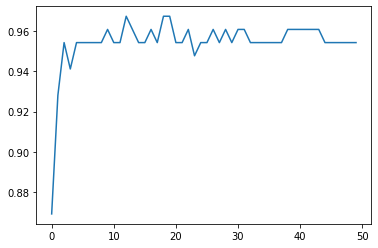

train Loss: 0.0518 Acc: 0.9795
val Loss: 0.1728 Acc: 0.9542

Epoch 51/4999
----------
train Loss: 0.0860 Acc: 0.9713
val Loss: 0.1758 Acc: 0.9542

Epoch 52/4999
----------
train Loss: 0.0392 Acc: 0.9877
val Loss: 0.1806 Acc: 0.9542

Epoch 53/4999
----------
train Loss: 0.0788 Acc: 0.9713
val Loss: 0.1778 Acc: 0.9542

Epoch 54/4999
----------
train Loss: 0.0597 Acc: 0.9795
val Loss: 0.1815 Acc: 0.9542

Epoch 55/4999
----------
train Loss: 0.0299 Acc: 0.9918
val Loss: 0.1823 Acc: 0.9542

Epoch 56/4999
----------
train Loss: 0.0399 Acc: 0.9836
val Loss: 0.1804 Acc: 0.9608

Epoch 57/4999
----------
train Loss: 0.0546 Acc: 0.9836
val Loss: 0.1785 Acc: 0.9542

Epoch 58/4999
----------
train Loss: 0.0783 Acc: 0.9672
val Loss: 0.1911 Acc: 0.9608

Epoch 59/4999
----------
train Loss: 0.0713 Acc: 0.9836
val Loss: 0.1758 Acc: 0.9542

Epoch 60/4999
----------
train Loss: 0.0770 Acc: 0.9754
val Loss: 0.1794 Acc: 0.9608

Epoch 61/4999
----------
train Loss: 0.0562 Acc: 0.9713
val Loss: 0.1766 Acc: 0

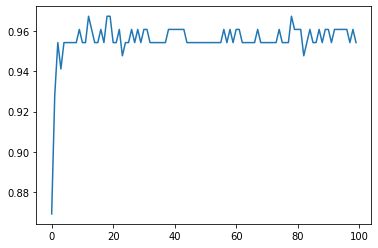

train Loss: 0.0520 Acc: 0.9918
val Loss: 0.1856 Acc: 0.9608

Epoch 101/4999
----------
train Loss: 0.0197 Acc: 0.9877
val Loss: 0.1817 Acc: 0.9608

Epoch 102/4999
----------
train Loss: 0.0273 Acc: 0.9918
val Loss: 0.1784 Acc: 0.9608

Epoch 103/4999
----------
train Loss: 0.0328 Acc: 0.9795
val Loss: 0.1775 Acc: 0.9608

Epoch 104/4999
----------
train Loss: 0.0576 Acc: 0.9795
val Loss: 0.1790 Acc: 0.9608

Epoch 105/4999
----------
train Loss: 0.0415 Acc: 0.9795
val Loss: 0.1812 Acc: 0.9608

Epoch 106/4999
----------
train Loss: 0.0272 Acc: 0.9877
val Loss: 0.1971 Acc: 0.9608

Epoch 107/4999
----------
train Loss: 0.0524 Acc: 0.9754
val Loss: 0.1905 Acc: 0.9608

Epoch 108/4999
----------
train Loss: 0.0369 Acc: 0.9836
val Loss: 0.1912 Acc: 0.9542

Epoch 109/4999
----------
train Loss: 0.0260 Acc: 0.9959
val Loss: 0.1938 Acc: 0.9542

Epoch 110/4999
----------
train Loss: 0.0265 Acc: 0.9877
val Loss: 0.1942 Acc: 0.9608

Epoch 111/4999
----------
train Loss: 0.0247 Acc: 0.9959
val Loss: 0.

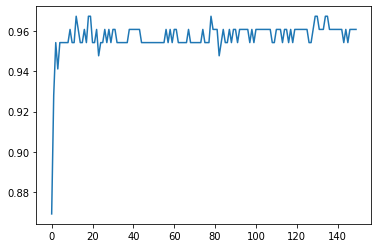

train Loss: 0.0223 Acc: 0.9877
val Loss: 0.1771 Acc: 0.9673

Epoch 151/4999
----------
train Loss: 0.0310 Acc: 0.9836
val Loss: 0.1709 Acc: 0.9542

Epoch 152/4999
----------
train Loss: 0.0235 Acc: 0.9959
val Loss: 0.1828 Acc: 0.9608

Epoch 153/4999
----------
train Loss: 0.0316 Acc: 0.9918
val Loss: 0.1769 Acc: 0.9608

Epoch 154/4999
----------
train Loss: 0.0498 Acc: 0.9877
val Loss: 0.1744 Acc: 0.9608

Epoch 155/4999
----------
train Loss: 0.0272 Acc: 0.9918
val Loss: 0.1765 Acc: 0.9542

Epoch 156/4999
----------
train Loss: 0.0493 Acc: 0.9836
val Loss: 0.1777 Acc: 0.9542

Epoch 157/4999
----------
train Loss: 0.0291 Acc: 0.9836
val Loss: 0.1835 Acc: 0.9542

Epoch 158/4999
----------
train Loss: 0.0510 Acc: 0.9836
val Loss: 0.1829 Acc: 0.9608

Epoch 159/4999
----------
train Loss: 0.0259 Acc: 0.9918
val Loss: 0.1802 Acc: 0.9608

Epoch 160/4999
----------
train Loss: 0.0298 Acc: 0.9877
val Loss: 0.1853 Acc: 0.9608

Epoch 161/4999
----------
train Loss: 0.0335 Acc: 0.9877
val Loss: 0.

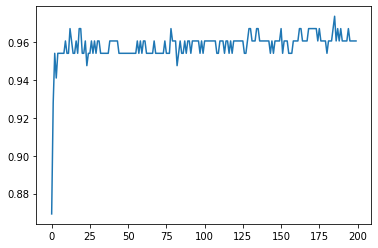

train Loss: 0.0313 Acc: 0.9877
val Loss: 0.1849 Acc: 0.9608

Epoch 201/4999
----------
train Loss: 0.0726 Acc: 0.9795
val Loss: 0.1794 Acc: 0.9608

Epoch 202/4999
----------
train Loss: 0.0266 Acc: 0.9877
val Loss: 0.1642 Acc: 0.9608

Epoch 203/4999
----------
train Loss: 0.0408 Acc: 0.9877
val Loss: 0.1626 Acc: 0.9608

Epoch 204/4999
----------
train Loss: 0.0346 Acc: 0.9836
val Loss: 0.1609 Acc: 0.9673

Epoch 205/4999
----------
train Loss: 0.0247 Acc: 0.9959
val Loss: 0.1677 Acc: 0.9608

Epoch 206/4999
----------
train Loss: 0.0512 Acc: 0.9754
val Loss: 0.1645 Acc: 0.9608

Epoch 207/4999
----------
train Loss: 0.0266 Acc: 0.9918
val Loss: 0.1568 Acc: 0.9673

Epoch 208/4999
----------
train Loss: 0.0176 Acc: 0.9959
val Loss: 0.1589 Acc: 0.9673

Epoch 209/4999
----------
train Loss: 0.0201 Acc: 0.9918
val Loss: 0.1613 Acc: 0.9673

Epoch 210/4999
----------
train Loss: 0.0104 Acc: 0.9959
val Loss: 0.1633 Acc: 0.9673

Epoch 211/4999
----------
train Loss: 0.0360 Acc: 0.9877
val Loss: 0.

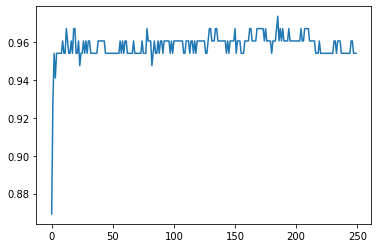

train Loss: 0.0250 Acc: 0.9877
val Loss: 0.2272 Acc: 0.9542

Epoch 251/4999
----------
train Loss: 0.0255 Acc: 0.9959
val Loss: 0.2276 Acc: 0.9608

Epoch 252/4999
----------
train Loss: 0.0361 Acc: 0.9918
val Loss: 0.2251 Acc: 0.9673

Epoch 253/4999
----------
train Loss: 0.0270 Acc: 0.9959
val Loss: 0.2210 Acc: 0.9673

Epoch 254/4999
----------
train Loss: 0.0321 Acc: 0.9795
val Loss: 0.2235 Acc: 0.9608

Epoch 255/4999
----------
train Loss: 0.0053 Acc: 1.0000
val Loss: 0.2262 Acc: 0.9542

Epoch 256/4999
----------
train Loss: 0.0241 Acc: 0.9918
val Loss: 0.2276 Acc: 0.9542

Epoch 257/4999
----------
train Loss: 0.0251 Acc: 0.9918
val Loss: 0.2293 Acc: 0.9608

Epoch 258/4999
----------
train Loss: 0.0226 Acc: 0.9959
val Loss: 0.2358 Acc: 0.9673

Epoch 259/4999
----------
train Loss: 0.0154 Acc: 0.9959
val Loss: 0.2341 Acc: 0.9673

Epoch 260/4999
----------
train Loss: 0.0392 Acc: 0.9836
val Loss: 0.2261 Acc: 0.9608

Epoch 261/4999
----------
train Loss: 0.0273 Acc: 0.9836
val Loss: 0.

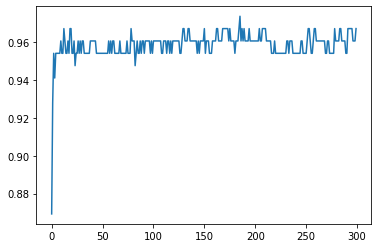

train Loss: 0.0381 Acc: 0.9795
val Loss: 0.2175 Acc: 0.9542

Epoch 301/4999
----------
train Loss: 0.0098 Acc: 0.9959
val Loss: 0.2191 Acc: 0.9542

Epoch 302/4999
----------
train Loss: 0.0424 Acc: 0.9836
val Loss: 0.2196 Acc: 0.9542

Epoch 303/4999
----------
train Loss: 0.0077 Acc: 0.9959
val Loss: 0.2179 Acc: 0.9542

Epoch 304/4999
----------
train Loss: 0.0224 Acc: 0.9959
val Loss: 0.2239 Acc: 0.9542

Epoch 305/4999
----------
train Loss: 0.0149 Acc: 0.9959
val Loss: 0.2291 Acc: 0.9542

Epoch 306/4999
----------
train Loss: 0.0296 Acc: 0.9877
val Loss: 0.2287 Acc: 0.9608

Epoch 307/4999
----------
train Loss: 0.0224 Acc: 0.9918
val Loss: 0.2297 Acc: 0.9608

Epoch 308/4999
----------
train Loss: 0.0339 Acc: 0.9836
val Loss: 0.2319 Acc: 0.9542

Epoch 309/4999
----------
train Loss: 0.0419 Acc: 0.9795
val Loss: 0.2330 Acc: 0.9542

Epoch 310/4999
----------
train Loss: 0.0236 Acc: 0.9877
val Loss: 0.2308 Acc: 0.9673

Epoch 311/4999
----------
train Loss: 0.0188 Acc: 0.9959
val Loss: 0.

In [ ]:
# Initialize the non-pretrained version of the model used for this run

# scratch_model,_ = initialize_model(model_name, num_classes, feature_extract=False, use_pretrained=False)

# ============= For fair comparison, should use pretrained, and only update the last few layers ===========
if model_name == "alexnet":
    scratch_model = models.alexnet(pretrained=True)
elif model_name == "vgg":
    scratch_model = models.vgg19(pretrained=True)
    
for param in scratch_model.features.parameters():
    param.requires_grad = False
    
for name, param in scratch_model.named_parameters():
    print("\t",name, param.requires_grad)
    
    
print(scratch_model)

scratch_model = scratch_model.to(device)
scratch_optimizer = optim.SGD(scratch_model.parameters(), lr=0.001, momentum=0.9)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=num_epochs, is_inception=(model_name=="inception"))

In [22]:

if model_name == "alexnet":
    torch.save(scratch_model.state_dict()['classifier.1.weight'], 'ant_bee_Alexnet_ScratchModel_acc9085_weight.pt')
    torch.save(scratch_model.state_dict()['classifier.1.bias'], 'ant_bee_Alexnet_ScratchModel_acc9085_bias.pt')
elif model_name == "vgg":
    torch.save(scratch_model.state_dict()['classifier.weight'], 'ant_bee_VGG19_ScratchModel_acc_weight.pt')
    torch.save(scratch_model.state_dict()['classifier.bias'], 'ant_bee_VGG19_ScratchModel_acc_bias.pt')

KeyError: 'classifier.weight'

In [23]:
scratch_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

Epoch 0/14
----------
train Loss: 0.6933 Acc: 0.5123
val Loss: 0.6941 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.6938 Acc: 0.4508
val Loss: 0.6922 Acc: 0.5425

Epoch 2/14
----------
train Loss: 0.6934 Acc: 0.4754
val Loss: 0.6928 Acc: 0.5817

Epoch 3/14
----------
train Loss: 0.6930 Acc: 0.5082
val Loss: 0.6926 Acc: 0.6275

Epoch 4/14
----------
train Loss: 0.6930 Acc: 0.5410
val Loss: 0.6925 Acc: 0.6013

Epoch 5/14
----------
train Loss: 0.6929 Acc: 0.5246
val Loss: 0.6912 Acc: 0.5425

Epoch 6/14
----------
train Loss: 0.6924 Acc: 0.5082
val Loss: 0.6913 Acc: 0.5817

Epoch 7/14
----------
train Loss: 0.6925 Acc: 0.5082
val Loss: 0.6904 Acc: 0.5425

Epoch 8/14
----------
train Loss: 0.6918 Acc: 0.5246
val Loss: 0.6910 Acc: 0.6601

Epoch 9/14
----------
train Loss: 0.6918 Acc: 0.5656
val Loss: 0.6904 Acc: 0.6471

Epoch 10/14
----------
train Loss: 0.6912 Acc: 0.5328
val Loss: 0.6892 Acc: 0.6405

Epoch 11/14
----------
train Loss: 0.6908 Acc: 0.5820
val Loss: 0.6898 Acc: 0.6144

Ep

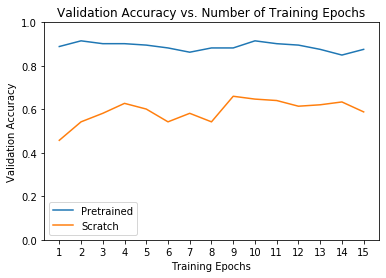

In [26]:
# Plot the training curves of validation accuracy vs. number 
#  of training epochs for the transfer learning method and
#  the model trained from scratch
ohist = []
shist = []

ohist = [h.cpu().numpy() for h in hist]
model_ft.featuresshist = [h.cpu().numpy() for h in scratch_hist]

plt.title("Validation Accuracy vs. Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Validation Accuracy")
plt.plot(range(1,num_epochs+1),ohist,label="Pretrained")
plt.plot(range(1,num_epochs+1),shist,label="Scratch")
plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

Final Thoughts and Where to Go Next
-----------------------------------

Try running some of the other models and see how good the accuracy gets.
Also, notice that feature extracting takes less time because in the
backward pass we do not have to calculate most of the gradients. There
are many places to go from here. You could:

-  Run this code with a harder dataset and see some more benefits of
   transfer learning
-  Using the methods described here, use transfer learning to update a
   different model, perhaps in a new domain (i.e. NLP, audio, etc.)
-  Once you are happy with a model, you can export it as an ONNX model,
   or trace it using the hybrid frontend for more speed and optimization
   opportunities.


